In [ ]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Images
using FFTW
using Statistics
using Interpolations
using DelimitedFiles

In [ ]:
computationID = "ThreeDVortex_64"

In [ ]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())
@inline inside_u(dims::NTuple{N}) where N = CartesianIndices((map(i->(2:i-1),dims)...,1:N))

In [ ]:
function InterpolOmega(xOrig,omega)
    x = xOrig .+ 2.0
    floorx = floor.(x)
    I = CartesianIndex(Int.(floorx)...)
    residual = x.-floorx
    N = length(I)
    s = 0.0
    for i ∈ N
        s += omega[I]*(1-residual[i]) + omega[I+δ(i,I)]*residual[i]
    end
    return s/N
end

In [78]:
function ComputeVorticity!(u, vortVec)
    for I∈inside(vortVec[:,:,:,1]) 
        vortVec[I,:] = WaterLily.ω(I,u)
    end
    WaterLily.BCPerVec!(vortVec)
end

function ComputeEntrophySpectrum!(vortVec, vortSpectrum)
    vortSpectrum .= 0.0
    magSlice = dropdims(Statistics.mean(vortVec, dims=3),dims=3)
    gridSize = size(magSlice)[1:2]
    ω̂ = magSlice*0im
    for i ∈ 1:3
        ω̂[:,:,i] = fft(magSlice[:,:,i])/prod(gridSize);
    end
    lx = fftfreq(gridSize[1],gridSize[1])
    ly = fftfreq(gridSize[2],gridSize[2])
    count = vortSpectrum*0
    for I in CartesianIndices(gridSize)
        l = sqrt(lx[I[1]]^2+ly[I[2]]^2)
        (l<0.5) && continue
        vortSpectrum[Int(round(l))] += sum(abs2.(ω̂[I,:]))
        count[Int(round(l))] += 1
    end
    vortSpectrum .*= (1:size(vortSpectrum)[1]).^2 ./ count
    vortSpectrum .+=1e-8
end

function StaggerToCollocateVel!(u, uInside)
    uInside .= 0.0
    uInside[:,:,:,1] = 0.5*(u[2:end-1,2:end-1,2:end-1,1]+u[3:end,2:end-1,2:end-1,1])
    uInside[:,:,:,2] = 0.5*(u[2:end-1,2:end-1,2:end-1,2]+u[2:end-1,3:end,2:end-1,2])
    uInside[:,:,:,3] = 0.5*(u[2:end-1,2:end-1,2:end-1,3]+u[2:end-1,2:end-1,3:end,3])
end

function ToCylindricalVel!(uInside, uCyl, rMat, CosThetaMat, SinThetaMat)
    uCyl .= 0
    u,v,w = uInside[:,:,:,1],uInside[:,:,:,2],uInside[:,:,:,3]
    uCyl[:,:,:,1] = u .* CosThetaMat .+ v .* SinThetaMat
    uCyl[:,:,:,2] =-u .* SinThetaMat .+ v .* CosThetaMat
    uCyl[:,:,:,3] = w*1.0
end

function ComputeMeanU!(uCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
    uCylFlat = Statistics.mean(uCyl,dims=3)
    gridSize = size(uCylFlat)
    uMeanRadial .= 0
    uMeanAzimuthal .= 0
    uMeanAxial .= 0
    sumR = similar(uMeanAxial)*0
    for I in CartesianIndices(gridSize[1:3])
        loc = Int(round(rMat[I]))
        uMeanRadial[loc] += uCylFlat[I,1]*rGaussianMat[I]
        uMeanAzimuthal[loc] += uCylFlat[I,2]*rGaussianMat[I]
        uMeanAxial[loc] += uCylFlat[I,3]*rGaussianMat[I]
        sumR[loc] += rGaussianMat[I]
    end
    uMeanRadial ./= sumR
    uMeanAzimuthal ./= sumR
    uMeanAxial ./= sumR
end

function ProjectCylMeanToCartesian!(uMeanFromCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
    r = 1 : (size(uMeanRadial)[1])
    uRadialInterpolator = linear_interpolation(r, uMeanRadial, extrapolation_bc=Interpolations.Line())
    uAzimuthalInterpolator = linear_interpolation(r, uMeanAzimuthal, extrapolation_bc=Interpolations.Line())
    uAxialInterpolator = linear_interpolation(r, uMeanAxial, extrapolation_bc=Interpolations.Line())
    uMeanFromCyl[:,:,1,1] = uRadialInterpolator.(rMat)
    uMeanFromCyl[:,:,1,2] = uAzimuthalInterpolator.(rMat)
    uMeanFromCyl[:,:,1,3] = uAxialInterpolator.(rMat)
end

function ComputeFluc!(uMeanFromCyl, uCyl, uFluc)
    uFluc .= uCyl.-uMeanFromCyl
end

function ComputePlanarTKE!(uFluc)
    return dropdims(Statistics.mean(sum(uFluc.^2,dims=4),dims=3),dims=(3,4))*0.5
end

ComputePlanarTKE! (generic function with 1 method)

In [ ]:
using GLMakie
GLMakie.activate!()
function makie_video!(makie_plot,sim,dat,obs_update!;remeasure=false,name="file.mp4",duration=1,step=0.1,framerate=30,compression=20)
    # Set up viz data and figure
    obs = obs_update!(dat,sim) |> Observable;
    fig, _, _ = makie_plot(obs)
    
    # Run simulation and update figure data
    t₀ = round(WaterLily.sim_time(sim))
    t = range(t₀,t₀+duration;step)
    iterations = size(t)[1]
    i = 1
    save("JLDs/"*computationID*"_"*string(i)*".jld","data",sim.flow.u)
    record(fig, name, t; framerate, compression) do tᵢ
        WaterLily.sim_step!(sim,tᵢ;remeasure)
        obs[] = obs_update!(dat,sim)
        i += 1
        ((i%10) == 1) && save("JLDs/"*computationID*"_"*string(i)*".jld","data",sim.flow.u)
        (i%(Int(round(iterations/20)))==1) && println("simulation ",round(Int,(tᵢ-t₀)/duration*100),"% complete")
    end
    return fig
end

function pureSimulation(sim; duration=1, step=0.1, remeasure=false)
    t₀ = round(WaterLily.sim_time(sim))
    t = range(t₀,t₀+duration;step)
    iterations = size(t)[1]
    i = 1
    WaterLily.sim_step!(sim,tᵢ;remeasure)
    ((i%10) == 1) && save("JLDs/"*computationID*"_"*string(i)*".jld","data",sim.flow.u)
end

using Meshing, GeometryBasics
function body_mesh(sim,t=0)
    a = sim.flow.σ; R = inside(a)
    WaterLily.measure_sdf!(a,sim.body,t)
    normal_mesh(GeometryBasics.Mesh(a[R]|>Array,MarchingCubes(),origin=Vec(0,0,0),widths=size(R)))
end;
function flow_λ₂!(dat,sim)
    a = sim.flow.σ
    for I∈inside(sim.flow.σ)
        a[I] = max(0,log10(-min(-1e-6,WaterLily.λ₂(I,sim.flow.u)*(sim.L/sim.U)^2))+.25)
    end
    copyto!(dat,a[inside(a)])                  # copy to CPU
end
function flow_λ₂(sim)
    dat = sim.flow.σ[inside(sim.flow.σ)] |> Array
    flow_λ₂!(dat,sim)
    dat
end


In [ ]:
function qVortex(; pow=8, Re=4000, T=Float32, mem=Array)
    # Define vortex size, velocity, viscosity
    Lp = 2^pow  # The grid of WaterLily is always Δx=Δy=Δz=1, so the length of domain is exactly the number of grids.
    delta0 = 1/16*Lp*0.892  # vortex core radius as 1/16 of the domain such that λ = 8dᵥ
    dᵥ = 2/0.892 # normalize Dv
    λ = 8dᵥ
    U = 4.0
    q = 1.0
    ν = delta0*U/Re

    # q-Vortex initial velocity field
    function uλ(i,xyz)
        # nomalized coordinate with basic length δ0
        x,y,z = @. (xyz-1.5-Lp/2)/delta0

        # converted to cylindrical coordinate
        r = sqrt(x^2+y^2) + 1e-10
        theta = atan(y,x)
        ξ = r/(4.001dᵥ)
        compactRSupport = max(0, (ξ^2-2)/(2*(ξ^2-1))*exp(ξ^2/(ξ^2-1)))

        # velocities in cylindrical coordinate
        uTheta  = q/r*U*(1-exp(-r^2))*compactRSupport
        uRadial = 0.00U/r*(1-exp(-r^2))/0.63817*sin(2*pi/λ*z)*compactRSupport
        uAxial  =     U*(1-exp(-r^2))  # wake-like axial flow

        zConnect = 1.0

        # return the velocity component in cartisian coordiante
        i==1 && return  uTheta*-sin(theta)+uRadial*cos(theta) # u_x
        i==2 && return  uTheta* cos(theta)+uRadial*sin(theta) # u_y
        i==3 && return  uAxial*zConnect    # u_z
        return 0
    end

    # Initialize simulation
    # (Lp, Lp, Lp) is the domain size, 
    # (0, 0, 0) specified the boundary BC. due to sepcial treatment in WaterLily, it is still slip instead of no-slip BC
    # delta0, U together define the length and velocity scales to normalize the simulation time
    return WaterLily.Simulation((Lp, Lp, Lp), (0, 0, 0), delta0; U, uλ, ν, T, mem)
end

In [ ]:
pow = 6

In [ ]:
intensity = 0.1
u = reshape(readdlm("u_vkp_64.64.64_1000_modes.txt", '\t', Float64, '\n', skipstart=2),(2^pow,2^pow,2^pow));
v = reshape(readdlm("v_vkp_64.64.64_1000_modes.txt", '\t', Float64, '\n', skipstart=2),(2^pow,2^pow,2^pow));
w = reshape(readdlm("w_vkp_64.64.64_1000_modes.txt", '\t', Float64, '\n', skipstart=2),(2^pow,2^pow,2^pow));
rms = sqrt(sum((u.^2+v.^2+w.^2)/(prod(size(u))+prod(size(v))+prod(size(w)))))
u ./= rms/intensity
v ./= rms/intensity
w ./= rms/intensity

uvw = zeros((size(u).+2)...,3)
uvw[3:end-1,2:end-1,2:end-1,1] = (u[1:end-1,:,:]+u[2:end,:,:])/2 
uvw[2:end-1,3:end-1,2:end-1,2] = (v[:,1:end-1,:]+v[:,2:end,:])/2 
uvw[2:end-1,2:end-1,3:end-1,3] = (w[:,:,1:end-1]+w[:,:,2:end])/2 
uvw[2,2:end-1,2:end-1,1] = (u[1,:,:]+u[end,:,:])/2 
uvw[2:end-1,2,2:end-1,2] = (v[:,1,:]+v[:,end,:])/2 
uvw[2:end-1,2:end-1,2,3] = (w[:,:,1]+w[:,:,end])/2 
WaterLily.BCPerVec!(uvw)

In [ ]:
size(uvw)

In [ ]:
sim = qVortex(pow=pow)
sim.flow.u .+= uvw;

In [ ]:
# Create a video using Makie
dat = sim.flow.σ[inside(sim.flow.σ)] |> Array; # CPU buffer array
function λ₂!(dat,sim)  # compute log10(-λ₂), where λ₂ has already been normalized by the prescribed length and time scales
    a = sim.flow.σ
    for I∈inside(sim.flow.σ)
        a[I] = log10(max(1e-6,-WaterLily.λ₂(I,sim.flow.u)*sim.L/sim.U))
    end
    copyto!(dat,a[inside(a)])                  # copy to CPU
end

In [ ]:
dur, step = 200, 0.1

In [ ]:
@time makie_video!(sim,dat,λ₂!,name=computationID*"_"*"qVortex.mp4",duration=200) do obs
    # plot the iso-surface of normalized λ₂ = 10⁻³, 10⁻², 10⁻¹, 10⁰
    GLMakie.contour(obs,levels=[-3,-2,-1,0],alpha=0.1,isorange=0.5)
end

┌ Info: Saved animation to /Users/tzuyaohuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_64_qVortexHIT.gif
└ @ Plots /Users/tzuyaohuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/Users/tzuyaohuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_64_qVortexHIT.gif")
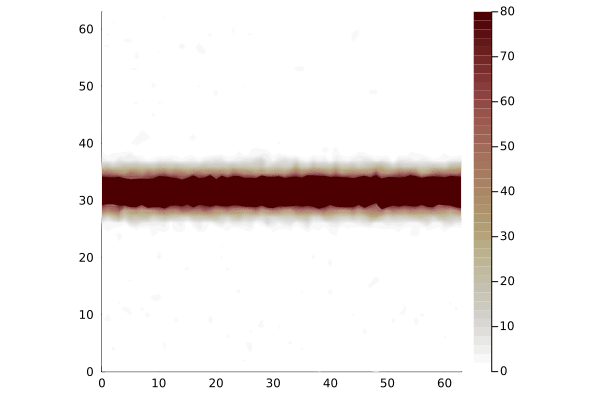

In [79]:
iterations = round(dur/step)
saveFrequency = 1/10
numFiles = Int(round(iterations*saveFrequency))

# read an example file to get size information
i = 1
fileName = "JLDs/"*computationID*"_"*string(i)*".jld"
uOriginAll = load(fileName)["data"]
gridSize = ntuple(i -> size(uOriginAll)[i]-2 ,3)

# make coordinate
xCoord = reshape(Array((1:gridSize[1]).-0.5 .-gridSize[1]/2), gridSize[1], 1, 1)
yCoord = reshape(Array((1:gridSize[2]).-0.5 .-gridSize[2]/2), 1, gridSize[2], 1)
rMat = sqrt.(xCoord.^2 .+ yCoord.^2)
thetaMat = atan.(yCoord,xCoord)
CosThetaMat = cos.(thetaMat)
SinThetaMat = sin.(thetaMat)
#
rRoundMat = Int.(round.(rMat))
rDiffMat = rMat .- rRoundMat
rGaussianMat = exp.(-0.2*rDiffMat.^2)

# construct storage array when processing
radialDirectionSize = Int(round(maximum(rMat)))
spectrumLength = Int(round(sqrt(sum((gridSize[1:2]./2).^2))))
#
uInside = zeros(gridSize...,3)
uCyl = similar(uInside)
uFluc = similar(uInside)
uMeanFromCyl = zeros(gridSize[1:2]...,1,3)
vortVec = zeros(size(uOriginAll))
#tkePlane = zeros(gridSize[1:2])
#
uMeanRadial = zeros(radialDirectionSize)
uMeanAzimuthal = zeros(radialDirectionSize)
uMeanAxial = zeros(radialDirectionSize)
vortSpectrum = zeros(spectrumLength)
flucSpectrum = zeros(spectrumLength)


# construct storage array to store the processed results
tkeList = zeros(numFiles)
mkeList = zeros(numFiles)
uMeanRadialList = zeros(radialDirectionSize,numFiles)
uMeanAzimuthalList = zeros(radialDirectionSize,numFiles)
uMeanAxialList = zeros(radialDirectionSize,numFiles)
vortSpectrumList = zeros(spectrumLength,numFiles)
flucSpectrumList = zeros(spectrumLength,numFiles)
tkeYList = zeros(gridSize[2],numFiles)

a = Animation()

for j ∈ 1:numFiles
    # read the file
    i = Int((j-1)/saveFrequency+1)
    fileName = "JLDs/"*computationID*"_"*string(i)*".jld"
    uOriginAll = load(fileName)["data"]


    # processing the velocity data
    ComputeVorticity!(uOriginAll, vortVec)
    vorticityMag = 0.5*dropdims(sum(vortVec.^2, dims=4), dims=4)*gridSize[1]     # normalized
    ComputeEntrophySpectrum!(vortVec[2:end-1,2:end-1,2:end-1,:], vortSpectrum)
    StaggerToCollocateVel!(uOriginAll, uInside)
    ToCylindricalVel!(uInside, uCyl, rMat, CosThetaMat, SinThetaMat)
    ComputeMeanU!(uCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
    ProjectCylMeanToCartesian!(uMeanFromCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
    ComputeFluc!(uMeanFromCyl, uCyl, uFluc)
    ComputeEntrophySpectrum!(uFluc, flucSpectrum)
    tkePlane = ComputePlanarTKE!(uFluc)
    # compute kinetic energy
    tke = 0.5*sum(uFluc.^2)
    mke = 0.5*sum(uMeanFromCyl.^2)*gridSize[3]

    # store the array
    uMeanRadialList[:,j] = uMeanRadial
    uMeanAzimuthalList[:,j] = uMeanAzimuthal
    uMeanAxialList[:,j] = uMeanAxial
    vortSpectrumList[:,j] = vortSpectrum
    flucSpectrumList[:,j] = flucSpectrum
    tkeList[j] = tke
    mkeList[j] = mke
    tkeYList[:,j] = (tkePlane[Int(gridSize[1]/2),:]+tkePlane[Int(gridSize[1]/2)+1,:])/2

    # make some plots
    plt = Plots.contourf(0:gridSize[3]-1, 0:gridSize[1]-1, vorticityMag[2:end-1,Int(gridSize[2]/2)+1,2:end-1], linewidth = 0, color=:bilbao, levels=40, clims = (0,80), aspect_ratio=:equal, xlim=(0,gridSize[1]-1), ylim=(0,gridSize[2]-1))
    frame(a,plt)
    # Plots.plot(uMeanRadial)
    # Plots.plot!(uMeanAzimuthal)
    # Plots.plot!(uMeanAxial)
    # print(tke, " ", mke)
end
gif(a, computationID*"_"*"qVortexHIT.gif")

┌ Info: Saved animation to /Users/tzuyaohuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_64_qVortex_velocityProfiles.gif
└ @ Plots /Users/tzuyaohuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/Users/tzuyaohuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_64_qVortex_velocityProfiles.gif")
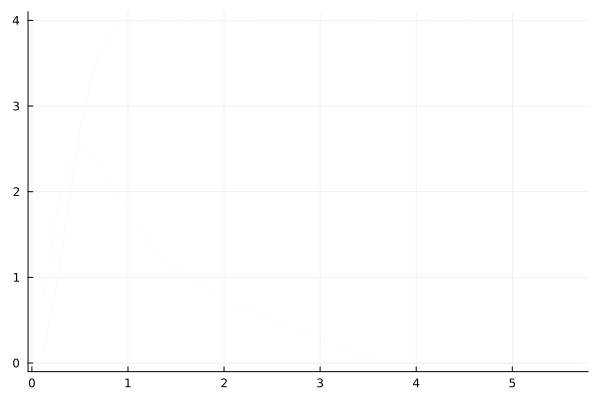

In [80]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    Plots.plot!((1:radialDirectionSize)/(1/8*gridSize[1]), uMeanAxialList[:,i],color=:blue, alpha=((i+50)/numFiles)^3,legend = false,ylimit=(-0.1,4.1))
    Plots.plot!((1:radialDirectionSize)/(1/8*gridSize[1]), uMeanAzimuthalList[:,i],color=:red, alpha=((i+50)/numFiles)^3,legend = false)
    plt = Plots.plot!((1:radialDirectionSize)/(1/8*gridSize[1]), uMeanRadialList[:,i],color=:green, alpha=((i+50)/numFiles)^3,legend = false)
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_velocityProfiles.png")
Plots.plot!()
gif(a,computationID*"_"*"qVortex_velocityProfiles.gif")

┌ Info: Saved animation to /Users/tzuyaohuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_64_qVortex_tkeYProfiles.gif
└ @ Plots /Users/tzuyaohuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/Users/tzuyaohuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_64_qVortex_tkeYProfiles.gif")
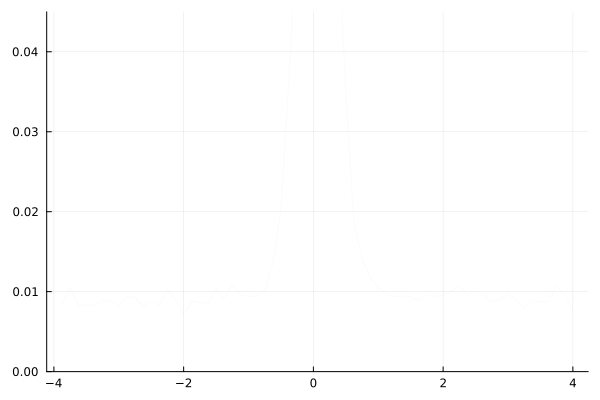

In [81]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    plt = Plots.plot!(((1:gridSize[1]).-gridSize[1]/2)/(1/8*gridSize[1]),tkeYList[:,i],color=:blue, alpha=((i+50)/numFiles)^3,legend = false,ylimit=(0,0.045))
    frame(a,plt)
end
Plots.plot!()
Plots.savefig(computationID*"_"*"qVortex_tkeYProfiles.png")

gif(a,computationID*"_"*"qVortex_tkeYProfiles.gif")

In [82]:
maximum(tkePlane)

UndefVarError: UndefVarError: `tkePlane` not defined

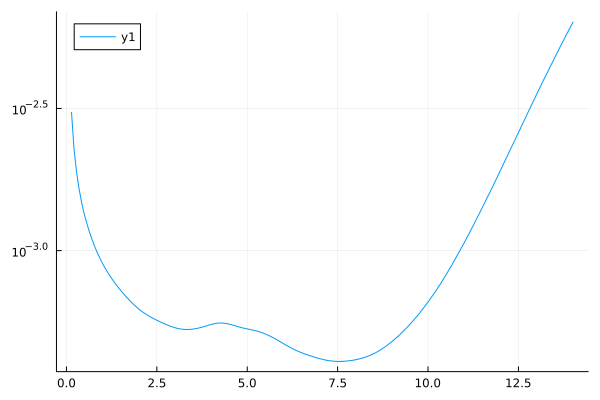

In [83]:
Plots.plot((2:200)/(1/16*2^8*0.892), (tkeList/(gridSize[1]*gridSize[2]*gridSize[3]))[2:end],yscale=:log10)
Plots.savefig(computationID*"_"*"qVortex_TKEEvolutions.png")
Plots.plot!()

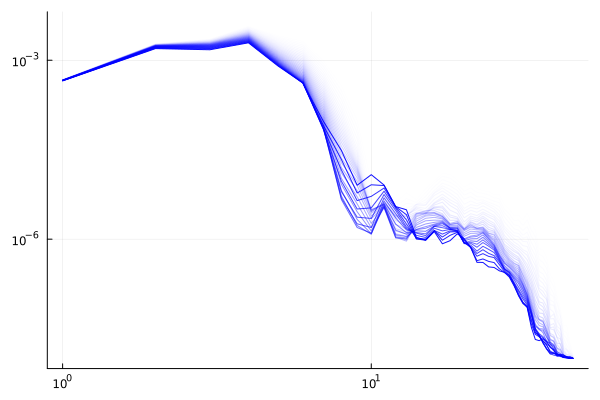

In [84]:
Plots.plot()
for i in 1:numFiles
    (i%5==1) && Plots.plot!(vortSpectrumList[:,i],color=:blue, alpha=((i)/numFiles)^3,xscale=:log10,yscale=:log10)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_Enstrophy.png")
Plots.plot!()

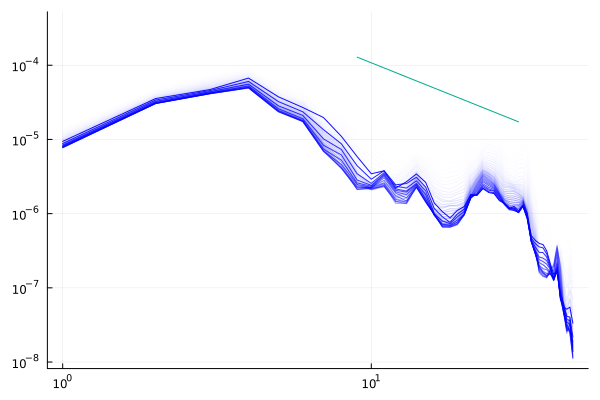

In [85]:
Plots.plot()
for i in 1:numFiles
    (i%5==1) && Plots.plot!(flucSpectrumList[:,i],color=:blue, alpha=((i)/numFiles)^3,xscale=:log10,yscale=:log10)
end
kk = 9:30
Plots.plot!(kk,0.005kk.^(-5/3))
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_tkeSpec.png")
Plots.plot!()